# Wine Recommendation System

by: Zachary Greenberg

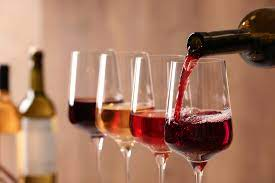

# Overview

The wine industry is gigantic. With extraordinarily large productions of wine comes so many choices. Utilizing Data Science, I intend to give personalized recommendations for wine selection. First, using the provided type of wine as a classifier, I will assess the accuracy of the provided textual reviews in predicting the wine. From here, I will utilize techniques including TF-IDF to vectorize the text and find recommendations based on cosine similarity and euclidean distances.

# Business Understanding

There are so many wines available, so how do you choose? Identifying new wines that are similar to the ones people enjoy will educate them about new bottles and wineries, allowing them to make more informed decisions when choosing their next bottle. Infact, with a roster of wines from a single winery, these companies could use this to recommend their other products.

# Data Understanding

The dataset was scraped from [Vivino.com](www.vivino.com). It contains mostly textual data, but some of the data is numeric. Each row is specific to a bottle of wine. It contains the following information:

-**winery**: str, the winery that makes that specific wine  
-**wine_name**: str, the name of the wine  
-**wine_type**: str, the classification of the wine (ie red, white)  
-**wine_country**: str, the country in which the wine was made  
-**average_rating**: float, the average rating of the wine on Vivino.com  
-**num_of_ratings**: int, the number of ratings for that wine on Vivino.com  
-**wine_price**: float, the price per bottle  
-**grapes**: str, the grapes utilized in the wine  
-**alcohol_content**: float, the percent alcohol in the wines  
-**reviews**: str, top 3 most helpful text reviews of the wine

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
#bringing in the dataframe
df = pd.read_csv('Data/wine_info.csv')

In [3]:
#checking the first 5 rows of the DataFrame
df.head()

winery           wine_name       wine_type wine_country  \
0  El Enemigo     Chardonnay 2018      White wine    Argentina   
1      Minuty         M Rosé 2020       Rosé wine       France   
2       Santi  Infinito Rosé 2018       Rosé wine        Italy   
3       Jansz   Premium Rosé N.V.  Sparkling wine    Australia   
4     Balbach       Riesling 2018      White wine      Germany   

   average_rating  num_of_ratings  wine_price  \
0             4.3            2239       23.99   
1             4.0             354       18.99   
2             3.8              93       12.29   
3             3.9            1460       29.00   
4             4.3              49       14.99   

                                         grapes  alcohol_content  \
0                               100% Chardonnay             13.8   
1  50% Grenache, 40% Cinsault, 10% Shiraz/Syrah             12.5   
2      65% Corvina, 30% Rondinella, 5% Molinara             12.0   
3         Pinot Meunier, Pinot Noir, Chardonnay             12.0   
4                                      Riesling              NaN   

                                             reviews  
0  4.25 perhaps. Apple, then more Chardonnay like...  
1  3,8. Pale salmon color. Nose of peach, strawbe...  
2  Dejlig, let neutral rosé. God til pizza ved ga...  
3  89/100 Blend of 78/22/ Pinot Noir and Chardonn...  
4  extraordinary balance between acidity and swee...

In [4]:
#This is the current size of the dataframe
df.shape

(1800, 10)

In [5]:
#checking for duplicates
sum(df.duplicated())

11

In [6]:
#dropping duplicates
df.drop_duplicates(inplace = True)

In [7]:
#checking the dtypes
df.dtypes

winery              object
wine_name           object
wine_type           object
wine_country        object
average_rating     float64
num_of_ratings       int64
wine_price         float64
grapes              object
alcohol_content    float64
reviews             object
dtype: object

The data are of the correct dtypes.

In [8]:
df.describe()

average_rating  num_of_ratings  wine_price  alcohol_content
count     1789.000000     1789.000000  1460.00000      1197.000000
mean         4.040190      794.282840    27.59587        14.142774
std          0.233302     1981.807234    13.78407         3.080135
min          2.600000       25.000000     9.99000         4.500000
25%          3.900000       66.000000    18.35000        12.500000
50%          4.100000      214.000000    25.99000        13.500000
75%          4.200000      656.000000    34.99000        15.000000
max          4.600000    27210.000000   192.99000        40.000000

Based on these summary statistics, these are my observations:
- Being that ratings are on a scale of 1-5, the average rating is quite high.  
- The range of prices for wines is from 9USD  to 192USD. This is quite a large range.  
- There seems to be a lot of missing values with alcohol_content. Not all of the entries on Vivino.com had this information readily available.

# Data Cleaning

In [9]:
#combining the winery and wine_name to get the full name of the product, the combination named 'title', and then 
#assigning it to the index
df['title'] = df['winery'].str.cat(df['wine_name'], sep = ' ')
df.set_index('title', inplace = True)

In [10]:
#creating a function to remove the year from the 'wine_name' column
def remove_year_in_name(x):
    '''
    This function removes the year from the 
    wine (name of wine) column.
    '''
    #These are the typical years of wines on Vivino.com
    if '17' or '18' or '19' or '20' in x:
        x = x[:-5]
        return x
    else:
        return x

I have decided to remove the year from the 'wine_name' column for easier filtering. The year will still be a part of the full 'title' variable that is now the index of the dataset. 

In [11]:
#applying the function above
df['wine_name'] = df['wine_name'].apply(remove_year_in_name)

In [12]:
df.isnull().sum()

winery               0
wine_name            0
wine_type            0
wine_country         0
average_rating       0
num_of_ratings       0
wine_price         329
grapes              19
alcohol_content    592
reviews              0
dtype: int64

This verifies that a good amount of the entries for alcohol_content are not available. Perhaps the column should be dropped. Wine price, I believe is something that can be imputed, as for the reviews, I would not suggest any filling techniques for the null values. 

In [13]:
#dropping the alcohol column
df.drop('alcohol_content', axis = 1, inplace = True)

With some of the price variables missing, I am going to impute them with the mean.

In [14]:
#imputing the mean
wine_mean = df.wine_price.mean()

df['wine_price'].fillna(wine_mean, inplace = True)

Below I will remove the null review entries.

In [15]:
#dropping the rows with the missing reviews
df.dropna(subset = ['reviews'], inplace = True)

In [16]:
#creating a function to fix a capitalization error
def lowercase_W(x):
    """
    This function changes the capitalization error
    in Fortified Wine
    """
    if x == 'Fortified Wine':
        x = 'Fortified wine'
        return x
    else:
        return x

In [17]:
df['wine_type'] = df['wine_type'].apply(lowercase_W)

In [18]:
#changing the wine_type to a single word
conditions = [df['wine_type'] == 'White wine',df['wine_type'] == 'Red wine',
               df['wine_type'] =='Sparkling wine',df['wine_type'] == 'Rosé wine', 
               df['wine_type'] =='Dessert wine', df['wine_type'] =='Fortified wine']
choices = ['White', 'Red', 'Sparkling', 'Rosé', 'Dessert', 'Fortified']

df['wine_type'] = np.select(conditions, choices)

In [19]:
#creating a function to clean the grape column
def clean_grape_column(x):
    '''
    This function cleans the entries in the grape
    column to make all grapes have 
    only 1 name. It removes the '100 %', and it
    also makes any 2 or more grapes in 1 wine 
    as a blend.
    '''
    if type(x) == float: #this will keep the NaN values in tact
        return x
    if ',' in x:
        return 'Blend'
    elif '%' in x:
        return ' '.join(x.split()[1:])
    else:
        return x
    

In [20]:
df['grapes'] = df['grapes'].apply(clean_grape_column)

In [21]:
df[df['grapes'].isna()].head(2)

winery  \
title                                                                   
Dancing Crow Vineyards Rosé 2019               Dancing Crow Vineyards   
Clos Sainte Magdeleine Côtes de Provence 2019  Clos Sainte Magdeleine   

                                                       wine_name wine_type  \
title                                                                        
Dancing Crow Vineyards Rosé 2019                            Rosé      Rosé   
Clos Sainte Magdeleine Côtes de Provence 2019  Côtes de Provence      Rosé   

                                                wine_country  average_rating  \
title                                                                          
Dancing Crow Vineyards Rosé 2019               United States             4.0   
Clos Sainte Magdeleine Côtes de Provence 2019         France             4.2   

                                               num_of_ratings  wine_price  \
title                                                                       
Dancing Crow Vineyards Rosé 2019                           29       17.33   
Clos Sainte Magdeleine Côtes de Provence 2019              53       32.99   

                                              grapes  \
title                                                  
Dancing Crow Vineyards Rosé 2019                 NaN   
Clos Sainte Magdeleine Côtes de Provence 2019    NaN   

                                                                                         reviews  
title                                                                                             
Dancing Crow Vineyards Rosé 2019               Juicy raspberry and strawberry with light swee...  
Clos Sainte Magdeleine Côtes de Provence 2019  Provence Rosé #💯 and my 1st wine back in 🇬🇧 (i...

I was hoping that for these NaN values that the name of the grape would be in the wine_name column as they typically would be a part of the name of the wine. Because they are not for these remaining N/A grapes, I will have to drop these rows. 

In [22]:
df.dropna(subset=['grapes'], inplace = True)

Now that I have categorized 2 or more grapes as a blend, I can get a little more specific in terms of the type of blend based on the type of wine:

In [23]:
#changing the Blend to Red, White Blend etc...
types = df['wine_type'].tolist()
grapes = df['grapes'].tolist()

for i, n in enumerate(grapes):
    if grapes[i] == 'Blend':
        grapes[i] = types[i] + ' ' + 'Blend'
        
df['grapes'] = grapes

In [24]:
df.shape

(1770, 9)

This dataset now has 1770 wines.

# Exploratory Data Analysis

In [25]:
#looking at unique wineries
df['winery'].nunique()

1053

In [26]:
#looking at the wines by winery
df.groupby('winery')['wine_name'].count().sort_values(ascending = False).head()

winery
Lustau      16
Quady       14
Sandeman    13
Taylor's    11
Warre's     10
Name: wine_name, dtype: int64

In [27]:
#creating a chart of wines by winery
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(header=dict(values=['Winery', 'Number of Wines']),
                 cells=dict(values=[['Lustau', 'Quady', 'Sandeman', 'Taylor\'s', 'Warre\'s'], [16, 14, 13, 11, 10]]))
                     ])
fig.update_layout(
    autosize=False,
    width=500,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=1
    ),
)
fig.show()

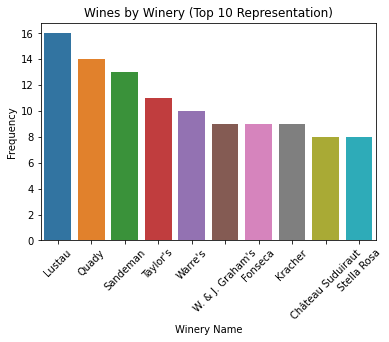

In [28]:
#creating a graph of wines by winery
labels = list(df.groupby('winery')['wine_name'].count().sort_values(ascending = False).head(10).index)

fig, ax = plt.subplots()
sns.barplot(x = df.groupby('winery')['wine_name'].count().sort_values(ascending = False).head(10).index, y = df.groupby('winery')['wine_name'].count().sort_values(ascending = False).head(10).values)
ax.set_title('Wines by Winery (Top 10 Representation)')
ax.set_xlabel('Winery Name')
ax.set_ylabel('Frequency')
ax.set_xticklabels(labels, rotation = 45);

It seems the Lustau winery has 16 different products represented in this dataset. There are a few other wineries with various products in this dataset. I will hopefully use that later on and create a version of a recommender based on winery.

In [29]:
#looking at the distributon of wine types
df['wine_type'].value_counts()

White        300
Red          299
Dessert      296
Rosé         293
Fortified    293
Sparkling    289
Name: wine_type, dtype: int64

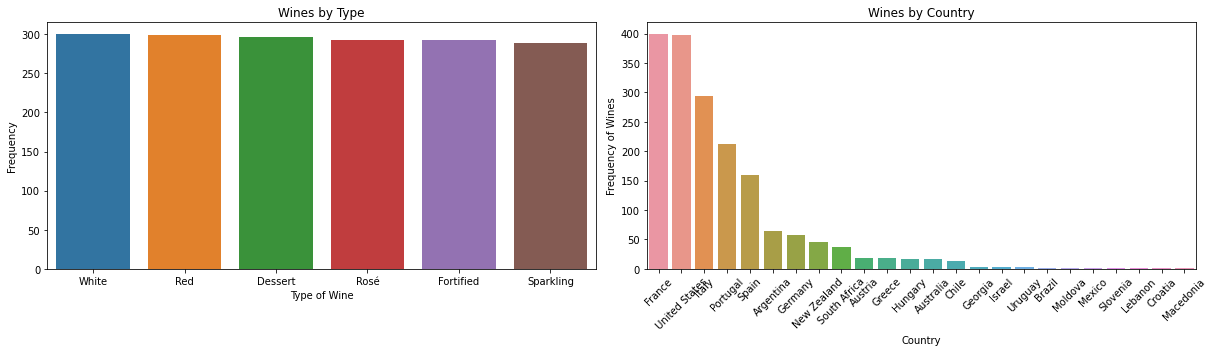

In [30]:
#graphing the distribution of wines by type and country
fig, axes = plt.subplots(1, 2, figsize=(17, 5))

one = sns.barplot(ax=axes[0], x=df['wine_type'].value_counts().index, y=df['wine_type'].value_counts().values)
axes[0].set_title('Wines by Type')
axes[0].set_xlabel('Type of Wine')
axes[0].set_ylabel('Frequency')

two = sns.barplot(ax=axes[1], x=df['wine_country'].value_counts().index, y=df['wine_country'].value_counts().values)
two.set_xticklabels(df['wine_country'].value_counts().index, rotation = 45)
axes[1].set_title('Wines by Country')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Frequency of Wines')

plt.tight_layout()
plt.savefig('Images/wine_graphs.png', facecolor='white' );

There seems to be a fairly even distribution of wines in the dataset. The majority of the wines in this dataset come from France, the United States and Italy. I did not find this surprising at all. 

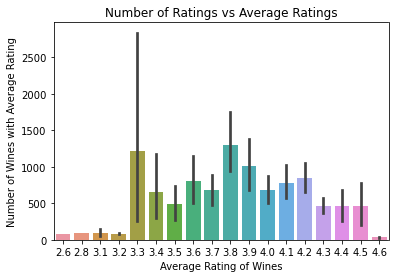

In [31]:
#graphing the ratings data
fig, ax = plt.subplots()
sns.barplot(df['average_rating'], df['num_of_ratings'])
ax.set_xlabel('Average Rating of Wines')
ax.set_ylabel('Number of Wines with Average Rating')
ax.set_title('Number of Ratings vs Average Ratings');

The ratings of wines are from 1 - 5. The range of ratings in this dataset is moreso in the middle. There is no rating less than 2.6 and none larger than 4.6. This means most of the wines have a fairly similar rating. The mode of the ratings collected is the 3.8 mark. This could be representative of truly average thoughts about the wine. 

In [32]:
df.grapes.value_counts().head()

Fortified Blend    153
Rosé Blend         133
Chardonnay         119
Sparkling Blend    108
Pinot Noir         106
Name: grapes, dtype: int64

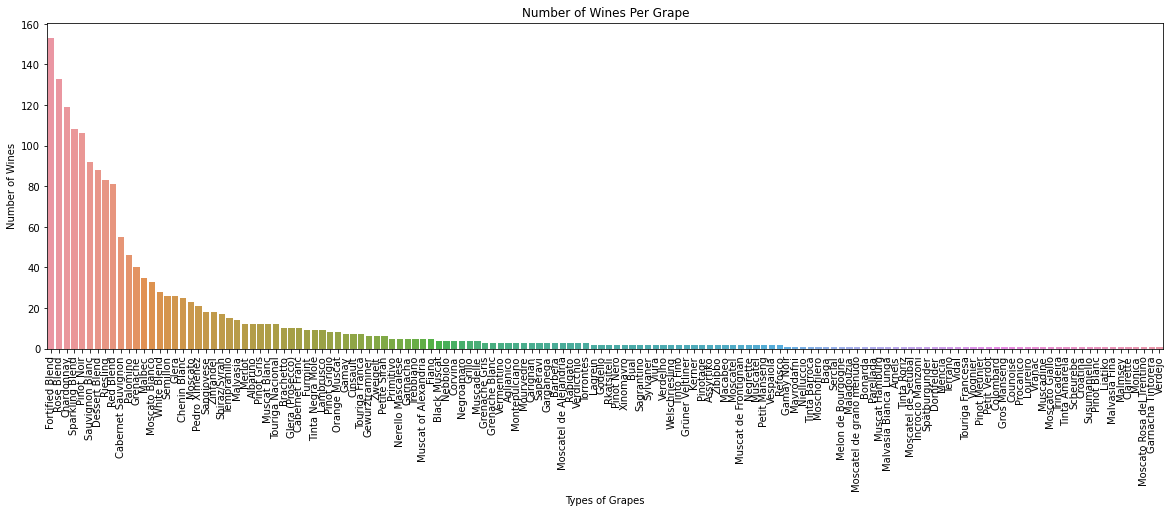

In [33]:
#graphing the number of wines per grape
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(df['grapes'].value_counts().index, df['grapes'].value_counts().values)
ax.set_xlabel('Types of Grapes')
ax.set_ylabel('Number of Wines')
ax.set_xticklabels(df['grapes'].value_counts().index, rotation = 90)
ax.set_title('Number of Wines Per Grape');

Most of the wines in this dataset are Fortified blends. Infact, I would say that blends make up the majority of wines in the dataset. This shows that the combination of grapes in a wine is a popular technique. 

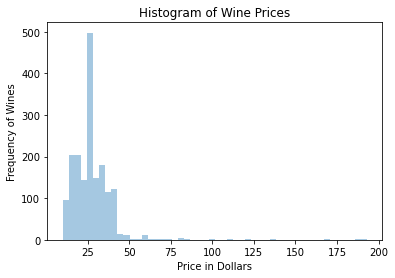

In [34]:
#graphing a histogram of wine prices
fig, ax = plt.subplots()
sns.distplot(df['wine_price'], kde = False)
ax.set_title('Histogram of Wine Prices')
ax.set_xlabel('Price in Dollars')
ax.set_ylabel('Frequency of Wines');

The majority of the wines prices seem to fall around the 25-30 USD mark. The range of the wines is quite large, giving room for suggestion to create a recommender based on price as another variation of a rec system. 

In [35]:
df.groupby('wine_type')['wine_price'].mean().index

Index(['Dessert', 'Fortified', 'Red', 'Rosé', 'Sparkling', 'White'], dtype='object', name='wine_type')

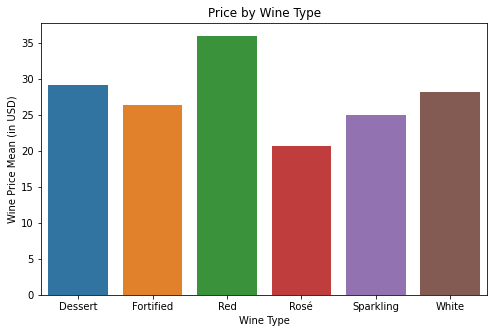

In [36]:
#graphing the price by wine type
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(df.groupby('wine_type')['wine_price'].mean().index, df.groupby('wine_type')['wine_price'].mean().values)
ax.set_xlabel('Wine Type')
ax.set_ylabel('Wine Price Mean (in USD)')
ax.set_title('Price by Wine Type');

It seems that red wine tends to be a bit pricer than others, however, in the scope of things, the difference in average price between the types of wine is not much. The range in price is only 15 USD. This means that if a person were to favor a specific wine type it would not cost them too much more for their preference.

# Data Preprocessing

## Natural Language Processing

Now that I understand the data better, I can move on to preprocessing the text reviews using NLP. In this step, I will be adding the grapes and wine types into the stopwords as well so that I can perform a Classification algorithm on them below.

In [37]:
#importing NLP libraries
from nltk.corpus import stopwords
from nltk import pos_tag
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [38]:
#generating the list of NLTK's typical english stop words
sw = stopwords.words('english') 

#this is a list of grapes lowercased to add to stopwords
wine_string = ','.join(list(df['grapes'].str.lower().unique()))
if ' ' in wine_string:
    wine_string = wine_string.replace(' ', ',')

grape_sw = wine_string.split(',')

#compiling a list of wine_types to add to stop words as well
kind_sw = []

for kind in list(df['wine_type'].unique()):
    kind = kind.lower().replace(' wine', '')
    kind_sw.append(kind)


#adding the grape & kind stop words to the list of all stop words
sw.extend(grape_sw)
sw.extend(kind_sw)

#adding additional words in as well that are unnecessary:
unnecessary_words = ['port', 'good', 'nice', 'smell', 'taste', 'mouth', 
                     'nose', 'great', 'note', 'finish', 'tannin', 
                     'wine', 'like', 'palate', 'aroma', 'one', 'hint',
                    'well', 'long', 'short', 'ro', 'ros', 'perfect',
                     'flavor', 'lovely', 'really', 'very', 'bit', 'little', 
                     'make', 'open', 'lot', 'go', 'big',
                    'age', 'brioche', 'bottle', 'drink', 'toast']
sw.extend(unnecessary_words)

In [39]:
def get_wordnet_pos(treebank_tag):
    '''
    This function will convert nltk POS 
    to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [40]:
def text_preparer(doc, stopwords=sw):
    '''
    This function takes in a document, and a list of
    stop words. It prepares the text by removing the numbers
    and punctuation (with Regex), lowercasing the 
    elements, and lemmatizing the text.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    #The lemmatizer wants to know what to look for:
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [41]:
#parsing the review text 
df['token_reviews'] = df['reviews'].apply(text_preparer)

In [42]:
#getting the groups together to make word clouds
White = df[df['wine_type'] == 'White']['token_reviews'].values.tolist()
Red = df[df['wine_type'] == 'Red']['token_reviews'].values.tolist()
Sparkling = df[df['wine_type'] == 'Sparkling']['token_reviews'].values.tolist()
Fortified = df[df['wine_type'] == 'Fortified']['token_reviews'].values.tolist()
Dessert = df[df['wine_type'] == 'Dessert']['token_reviews'].values.tolist()
Rosé = df[df['wine_type'] == 'Rosé']['token_reviews'].values.tolist()
texts = [White, Red, Sparkling, Fortified, Dessert, Rosé]

#these will be the labels for word clouds
labels = ['White', 'Red', 'Sparkling', 'Fortified', 'Dessert', 'Rosé']

In [43]:
from wordcloud import WordCloud

def show_wordcloud(data, labels):
    """
    This function takes a list of text data variables
    (the data itself must also being in list form) 
    and it also takes a list of labels and returns 
    a word cloud.
    """
    i = 0
    for group in data:
        wordcloud = WordCloud(
            background_color='black',
            stopwords=sw,
            max_words=30, 
            scale=3,
            random_state=12
        ).generate(str(group))

        fig = plt.figure(1, figsize=(6, 6))
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(wordcloud)
        plt.tight_layout(pad=0)
        #This saves each figure individually!
        plt.savefig(f'Images/{labels[i]}Cloud.png', transparent = True) 
        plt.show()
        i+=1

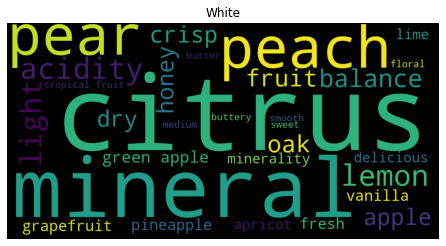

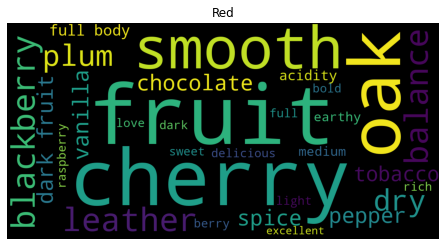

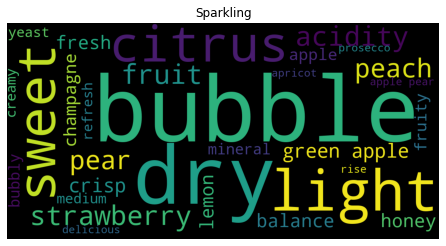

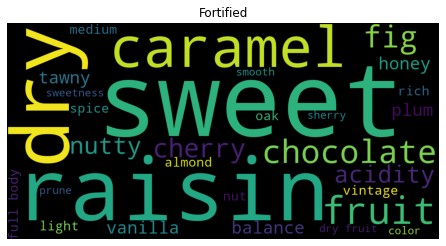

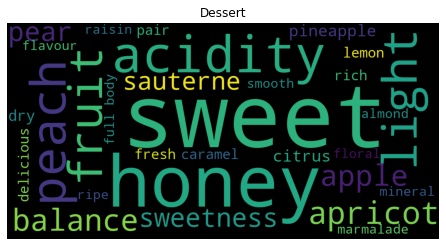

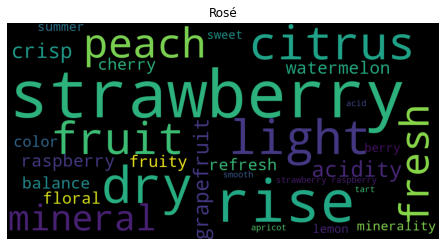

In [44]:
#generating word clouds for each of the wine types
show_wordcloud(texts, labels)

With some domain knowledge of the conventional descriptions of these wine types, I would say that these reviews seem to do a good job of characterizing their labels.

## Vectorization & Standardization

Before I do some modeling, I will use TFIDF to vectorize my text reviews, merge the array to the DataFrame, and scale:

In [45]:
#getting dummy columns for the categorical variables
dummy_columns = ['wine_country', 'grapes']

df_model = pd.get_dummies(df, columns = dummy_columns)

In [46]:
#vectorizing text reviews
from sklearn.feature_extraction.text import TfidfVectorizer

#setting the parameters to be able to filter for top words
tfidfvec = TfidfVectorizer(sublinear_tf=True, max_df=.9, min_df=.05,  ngram_range=(1, 1))
tf_idfwine = tfidfvec.fit_transform((df_model['token_reviews']))

In [47]:
#using feature_names to see the top words
df_tfidf = pd.DataFrame(tf_idfwine.toarray(), columns = tfidfvec.get_feature_names())

In [48]:
df_tfidf.head(2)

acid  acidic   acidity  aftertaste  age  alcohol  almond  almost  also  \
0  0.000000     0.0  0.148698    0.000000  0.0  0.26527     0.0     0.0   0.0   
1  0.191179     0.0  0.000000    0.370081  0.0  0.00000     0.0     0.0   0.0   

      apple  ...  vanilla   vintage  watermelon  way  wine  wonderful  would  \
0  0.196106  ...      0.0  0.250243    0.000000  0.0   0.0   0.327096    0.0   
1  0.000000  ...      0.0  0.000000    0.228712  0.0   0.0   0.000000    0.0   

   year    yellow  zest  
0   0.0  0.288779   0.0  
1   0.0  0.000000   0.0  

[2 rows x 163 columns]

In [49]:
#dropping unnecessary columns from the df_model DataFrame
model_data = df_model.drop(labels = ['winery', 'wine_name', 'wine_type', 'reviews', 'token_reviews'], axis = 1)
model_data = pd.concat([model_data.reset_index(), df_tfidf], axis = 1)
model_data.set_index('title', inplace = True)

In [50]:
model_data.columns[:3] #aside from the dummy variables and vectorized columns, these are the other ones in the model

Index(['average_rating', 'num_of_ratings', 'wine_price'], dtype='object')

In [51]:
#scaling the new matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(model_data)

scale_model_data = pd.DataFrame(scaler.transform(model_data), columns = model_data.columns, index = model_data.index)

# Modeling

## Classification

As a form of supervised learning, and a clarity check, I am going to perform some Classification algorithms on the text reviews and assess their accuracy on identifying the type of wine in the 'wine_types' column.

### Random Forest 

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X = df['reviews']
y = df['wine_type']

In [54]:
#splitting the data
X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .8, random_state= 13)

In [55]:
#creating a RandomForest pipeline with a grid search
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
accuracy = make_scorer(accuracy_score)

pipeline = Pipeline([
                    ('tv', TfidfVectorizer()),
                    ('rf', RandomForestClassifier(random_state=42))
                    ])


rf_param_grid_pipe = {
    "rf__criterion": ["gini", "entropy"],
    "rf__max_depth": [None, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16],
    "rf__max_features": [None,4,5,6,9,10],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf" : [1, 2, 3, 5, 6],
    "rf__n_estimators" : [10, 30, 100]
}


grid_search_pipe = GridSearchCV(pipeline, rf_param_grid_pipe, cv=3, verbose=1, n_jobs=-1, scoring = accuracy)

grid_search_pipe.fit(X_train, y_train)

Fitting 3 folds for each of 5940 candidates, totalling 17820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tv', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [None, 2, 3, 4, 5, 6, 8, 10, 12, 14,
                                           16],
                         'rf__max_features': [None, 4, 5, 6, 9, 10],
                         'rf__min_samples_leaf': [1, 2, 3, 5, 6],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [10, 30, 100]},
             scoring=make_scorer(accuracy_score), verbose=1)

In [56]:
print(grid_search_pipe.best_params_)

{'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__max_features': 9, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}


In [57]:
grid_search_pipe.score(X_test, y_test)

0.7768361581920904

78% accuracy is not too terrible. I would be curious to see if a MultiNomial Naive Bayes model would have better accuracy performance. 

### MultiNomial Bayes

In [58]:
from sklearn.naive_bayes import MultinomialNB

mb = Pipeline([
                    ('tv', TfidfVectorizer()),
                    ('mb', MultinomialNB())
                    ])

param_grid_pipe = {
    "mb__alpha": [1, .5, .25, .75],
    
}


grid_search_pipe = GridSearchCV(mb, param_grid_pipe, cv=3, verbose=1, n_jobs=-1, scoring=accuracy)
grid_search_pipe.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tv', TfidfVectorizer()),
                                       ('mb', MultinomialNB())]),
             n_jobs=-1, param_grid={'mb__alpha': [1, 0.5, 0.25, 0.75]},
             scoring=make_scorer(accuracy_score), verbose=1)

In [59]:
print(grid_search_pipe.best_params_)

{'mb__alpha': 0.25}


In [60]:
grid_search_pipe.score(X_test, y_test)

0.8333333333333334

When comparing the two algorithms, the Multinomial Bayes gave a higher accuracy score. I will now run a model with those parameters to look at the confusion matrix.

In [61]:
mb = Pipeline([
                    ('tv', TfidfVectorizer()),
                    ('mb', MultinomialNB(alpha = .25))
                    ])

mb.fit(X_train, y_train)

Pipeline(steps=[('tv', TfidfVectorizer()), ('mb', MultinomialNB(alpha=0.25))])

In [62]:
y_pred_mb = mb.predict(X_test)

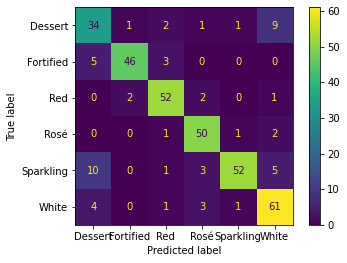

In [63]:
from sklearn.metrics import plot_confusion_matrix, classification_report
plot_confusion_matrix(mb,y_pred_mb, y_test)
plt.savefig('Images/Matrix.png');

The sparkling and dessert wine categories seemed to perform the worst out of all them. I believe this is due to the broadness of the categories themselves. The other categories seem to be a little more specifically defined.

In [64]:
from sklearn.metrics import plot_confusion_matrix, classification_report
print(classification_report(y_test, y_pred_mb))

              precision    recall  f1-score   support

     Dessert       0.64      0.71      0.67        48
   Fortified       0.94      0.85      0.89        54
         Red       0.87      0.91      0.89        57
        Rosé       0.85      0.93      0.88        54
   Sparkling       0.95      0.73      0.83        71
       White       0.78      0.87      0.82        70

    accuracy                           0.83       354
   macro avg       0.84      0.83      0.83       354
weighted avg       0.84      0.83      0.83       354



The reviews show an 83% accuracy of identifying the types of wine. This shows that the reviews can be helpful in making recommendations. 

## Recommender Systems

### By Title (Wine Full Name)

#### Cosine Similarity Model

In [65]:
from sklearn.metrics.pairwise import cosine_similarity

#calculating the cosine similarities of the model on itself.
cos_sim = cosine_similarity(scale_model_data, scale_model_data)

In [66]:
# Storing indices of the data
indices = pd.Series(df.index)
  
def cosine_recommendations(title, cos_sim, num_recommendations):
    """
    This function takes in a title from the index along 
    with the cosine similarity array, and number of recommendations. 
    It returns the top wines recommended with the highest similarity
    scores.
    """
    recommended_wines = []
    index = indices[indices == title].index[0]
    similarity_scores = pd.Series(cos_sim[index]).sort_values(ascending = False)
    top_recommended_wines = list(similarity_scores.iloc[1:num_recommendations+1].index)
    for i in top_recommended_wines:
        recommended_wines.append(list(df_model.index)[i])
        matches = df.loc[recommended_wines][['wine_type', 'wine_country', 'grapes', 'average_rating', 'wine_price']]
    matches['cosine_similarity_scores'] = list(similarity_scores.iloc[1:num_recommendations+1].values)
    return matches

In [67]:
print('Cosine Similarity Model by Title \n1000 Stories Chardonnay 2018')
stories_cosine = cosine_recommendations("1000 Stories Chardonnay 2018", cos_sim, 10)
stories_cosine

Cosine Similarity Model by Title 
1000 Stories Chardonnay 2018


wine_type   wine_country  \
title                                                                          
Brown Estate House of Brown Chardonnay 2018             White  United States   
Miner Chardonnay 2018                                   White  United States   
The Prisoner The Snitch Chardonnay 2018                 White  United States   
Buena Vista The Sheriff of Buena Vista 2018               Red  United States   
Ministry of The Vinterior Pinot Noir 2017                 Red  United States   
MacRostie Wildcat Mountain Vineyard Chardonnay ...      White  United States   
Laguna Chardonnay 2017                                  White  United States   
EnRoute Brumaire Chardonnay 2019                        White  United States   
Le Mesnil Blanc de Blancs Brut Champagne Grand Cru  Sparkling         France   
Andresen 20 Year Old White Porto N.V.               Fortified       Portugal   

                                                             grapes  \
title                                                                 
Brown Estate House of Brown Chardonnay 2018              Chardonnay   
Miner Chardonnay 2018                                    Chardonnay   
The Prisoner The Snitch Chardonnay 2018                  Chardonnay   
Buena Vista The Sheriff of Buena Vista 2018               Red Blend   
Ministry of The Vinterior Pinot Noir 2017                Pinot Noir   
MacRostie Wildcat Mountain Vineyard Chardonnay ...       Chardonnay   
Laguna Chardonnay 2017                                   Chardonnay   
EnRoute Brumaire Chardonnay 2019                         Chardonnay   
Le Mesnil Blanc de Blancs Brut Champagne Grand Cru       Chardonnay   
Andresen 20 Year Old White Porto N.V.               Fortified Blend   

                                                    average_rating  \
title                                                                
Brown Estate House of Brown Chardonnay 2018                    4.2   
Miner Chardonnay 2018                                          4.2   
The Prisoner The Snitch Chardonnay 2018                        4.2   
Buena Vista The Sheriff of Buena Vista 2018                    4.4   
Ministry of The Vinterior Pinot Noir 2017                      4.3   
MacRostie Wildcat Mountain Vineyard Chardonnay ...             4.2   
Laguna Chardonnay 2017                                         4.2   
EnRoute Brumaire Chardonnay 2019                               4.3   
Le Mesnil Blanc de Blancs Brut Champagne Grand Cru             4.0   
Andresen 20 Year Old White Porto N.V.                          4.2   

                                                    wine_price  \
title                                                            
Brown Estate House of Brown Chardonnay 2018           25.00000   
Miner Chardonnay 2018                                 26.99000   
The Prisoner The Snitch Chardonnay 2018               24.47000   
Buena Vista The Sheriff of Buena Vista 2018           39.99000   
Ministry of The Vinterior Pinot Noir 2017             28.99000   
MacRostie Wildcat Mountain Vineyard Chardonnay ...    38.75000   
Laguna Chardonnay 2017                                18.35000   
EnRoute Brumaire Chardonnay 2019                      32.63000   
Le Mesnil Blanc de Blancs Brut Champagne Grand Cru    35.19000   
Andresen 20 Year Old White Porto N.V.                 27.59587   

                                                    cosine_similarity_scores  
title                                                                         
Brown Estate House of Brown Chardonnay 2018                         0.436542  
Miner Chardonnay 2018                                               0.414314  
The Prisoner The Snitch Chardonnay 2018                             0.310151  
Buena Vista The Sheriff of Buena Vista 2018                         0.288712  
Ministry of The Vinterior Pinot Noir 2017                           0.282954  
MacRostie Wildcat Mountain Vineyard Chardonnay ... 

In [68]:
df.loc['1000 Stories Chardonnay 2018'][['wine_type', 'wine_country', 'grapes', 'average_rating', 'wine_price']]

wine_type                 White
wine_country      United States
grapes               Chardonnay
average_rating              4.1
wine_price                17.99
Name: 1000 Stories Chardonnay 2018, dtype: object

Using Cosine Similarity as a metric, these are the top 10 wines that are similar to the '1000 Stories Chardonnay 2018' wine I have set as a parameter to the function. The majority of the other wines recommended are also US Chardonnays.

#### Euclidean Distance

In [69]:
from sklearn.metrics.pairwise import euclidean_distances

euc_dist = euclidean_distances(scale_model_data, scale_model_data)

In [70]:
# Storing indices of the data
indices = pd.Series(df.index)
  
def euclidean_recommendations(title, euc_dist, num_recommendations):
    """
    This function takes in a title from the index along 
    with the euclidean distance array, and number of
    recommendations. It returns the top recommended wines
    with the lowest distance scores.
    """
    recommended_wines = []
    index = indices[indices == title].index[0]
    distance_scores = pd.Series(euc_dist[index]).sort_values(ascending = True)
    top_10_wines = list(distance_scores.iloc[1:num_recommendations+1].index)
    for i in top_10_wines:
        recommended_wines.append(list(df_model.index)[i])
        matches = df.loc[recommended_wines][['wine_type', 'wine_country', 'grapes', 'average_rating', 'wine_price']]
    matches['euclidean_distance_scores'] = list(distance_scores.iloc[1:num_recommendations+1].values)
    return matches
        

In [71]:
print('Euclidean Distance Model')
print('1000 Stories Chardonnay 2018 ')
stories_euclidean = euclidean_recommendations("1000 Stories Chardonnay 2018", euc_dist, 10)
stories_euclidean

Euclidean Distance Model
1000 Stories Chardonnay 2018 


wine_type   wine_country  \
title                                                                          
Brown Estate House of Brown Chardonnay 2018             White  United States   
Miner Chardonnay 2018                                   White  United States   
The Prisoner The Snitch Chardonnay 2018                 White  United States   
Ministry of The Vinterior Pinot Noir 2017                 Red  United States   
The Calling Dutton Ranch Chardonnay 2017                White  United States   
Le Mesnil Blanc de Blancs Brut Champagne Grand Cru  Sparkling         France   
Andresen 20 Year Old White Porto N.V.               Fortified       Portugal   
Laguna Chardonnay 2017                                  White  United States   
Flor Brut Rosé N.V.                                 Sparkling          Italy   
Domaine Carneros Brut 2016                          Sparkling  United States   

                                                             grapes  \
title                                                                 
Brown Estate House of Brown Chardonnay 2018              Chardonnay   
Miner Chardonnay 2018                                    Chardonnay   
The Prisoner The Snitch Chardonnay 2018                  Chardonnay   
Ministry of The Vinterior Pinot Noir 2017                Pinot Noir   
The Calling Dutton Ranch Chardonnay 2017                 Chardonnay   
Le Mesnil Blanc de Blancs Brut Champagne Grand Cru       Chardonnay   
Andresen 20 Year Old White Porto N.V.               Fortified Blend   
Laguna Chardonnay 2017                                   Chardonnay   
Flor Brut Rosé N.V.                                      Pinot Noir   
Domaine Carneros Brut 2016                          Sparkling Blend   

                                                    average_rating  \
title                                                                
Brown Estate House of Brown Chardonnay 2018                    4.2   
Miner Chardonnay 2018                                          4.2   
The Prisoner The Snitch Chardonnay 2018                        4.2   
Ministry of The Vinterior Pinot Noir 2017                      4.3   
The Calling Dutton Ranch Chardonnay 2017                       4.1   
Le Mesnil Blanc de Blancs Brut Champagne Grand Cru             4.0   
Andresen 20 Year Old White Porto N.V.                          4.2   
Laguna Chardonnay 2017                                         4.2   
Flor Brut Rosé N.V.                                            4.1   
Domaine Carneros Brut 2016                                     4.1   

                                                    wine_price  \
title                                                            
Brown Estate House of Brown Chardonnay 2018           25.00000   
Miner Chardonnay 2018                                 26.99000   
The Prisoner The Snitch Chardonnay 2018               24.47000   
Ministry of The Vinterior Pinot Noir 2017             28.99000   
The Calling Dutton Ranch Chardonnay 2017              22.99000   
Le Mesnil Blanc de Blancs Brut Champagne Grand Cru    35.19000   
Andresen 20 Year Old White Porto N.V.                 27.59587   
Laguna Chardonnay 2017                                18.35000   
Flor Brut Rosé N.V.                                   19.99000   
Domaine Carneros Brut 2016                            27.99000   

                                                    euclidean_distance_scores  
title                                                                          
Brown Estate House of Brown Chardonnay 2018                         14.060775  
Miner Chardonnay 2018                                               14.454876  
The Prisoner The Snitch Chardonnay 2018                             15.849033  
Ministry of The Vinterior Pinot Noir 2017                           16.072130  
The Calling Dutton Ranch Chardonnay 2017                            16.322660  
Le Mesnil Blanc de Blancs Brut Champagne Gra

This time, using Euclidean Distance as a metric, these are the top 10 wines recommended for that same bottle. Again, it seems logical so far because most of these wines are US Chardonnays like the original one in the input. 

In order to compare the two methods together, I think I will have to check the wine_price and wine_rating variables. I am hoping this will probably give a better sense of which method yielded the best results.

In [72]:
#creating a dataframe to get a closer look at the other variables.
pd.DataFrame({'1000 Stories Chardonnay 2018': [df.loc['1000 Stories Chardonnay 2018']['average_rating'], df.loc['1000 Stories Chardonnay 2018']['wine_price']],
             'Cosine Model': [stories_cosine['average_rating'].mean(), stories_cosine['wine_price'].mean()], 
             'Euclidean Model': [stories_euclidean['average_rating'].mean(), stories_euclidean['wine_price'].mean()]}, index = ['Average Rating', 'Wine Price'])

1000 Stories Chardonnay 2018  Cosine Model  Euclidean Model
Average Rating                          4.10      4.220000         4.160000
Wine Price                             17.99     29.795587        25.755587

Taking a closer look at the other two variables, rating and price, it is a close call. The Euclidean Model seems to be a little bit closer to the average rating and wine price of the Stories Chardonnay bottle. This is based on it's overall average of those columns. 

### By Winery

#### Cosine Similarity

In this dataset, there were 16 wines produced by a single winery. I would be curious to see these recommendations.

In [73]:
df[df['winery'] == 'Lustau'].head(2)

winery  \
title                                                        
Lustau Don Nuño Dry Oloroso Sherry (Reserva Sol...  Lustau   
Lustau Los Arcos Dry Amontillado Sherry (Solera...  Lustau   

                                                                                            wine_name  \
title                                                                                                   
Lustau Don Nuño Dry Oloroso Sherry (Reserva Sol...       Don Nuño Dry Oloroso Sherry (Reserva Solera)   
Lustau Los Arcos Dry Amontillado Sherry (Solera...  Los Arcos Dry Amontillado Sherry (Solera Reserva)   

                                                    wine_type wine_country  \
title                                                                        
Lustau Don Nuño Dry Oloroso Sherry (Reserva Sol...  Fortified        Spain   
Lustau Los Arcos Dry Amontillado Sherry (Solera...  Fortified        Spain   

                                                    average_rating  \
title                                                                
Lustau Don Nuño Dry Oloroso Sherry (Reserva Sol...             3.7   
Lustau Los Arcos Dry Amontillado Sherry (Solera...             3.6   

                                                    num_of_ratings  \
title                                                                
Lustau Don Nuño Dry Oloroso Sherry (Reserva Sol...            1200   
Lustau Los Arcos Dry Amontillado Sherry (Solera...            1869   

                                                    wine_price    grapes  \
title                                                                      
Lustau Don Nuño Dry Oloroso Sherry (Reserva Sol...    27.59587  Palomino   
Lustau Los Arcos Dry Amontillado Sherry (Solera...    16.99000  Palomino   

                                                                                              reviews  \
title                                                                                                   
Lustau Don Nuño Dry Oloroso Sherry (Reserva Sol...  Oxidated ripening and deep garnet colour. Very...   
Lustau Los Arcos Dry Amontillado Sherry (Solera...  Edgar Allan Poe wrote about a Cask of Amontila...   

                                                                                        token_reviews  
title                                                                                                  
Lustau Don Nuño Dry Oloroso Sherry (Reserva Sol...  oxidate ripen deep garnet colour aromatic arou...  
Lustau Los Arcos Dry Amontillado Sherry (Solera...  edgar allan poe write cask amontilado certainl...

In [74]:
#creating a dataframe of the wines from the Lustau winery in Spain
lustau = df[df['winery'] == 'Lustau']

print('Cosine Similarity Model by Winery')
lustau_cosine = cosine_recommendations('Lustau San Emilio Pedro Ximenez N.V.', cos_sim, 10)
lustau_cosine

Cosine Similarity Model by Winery


wine_type wine_country  \
title                                                                        
Alvear Pedro Ximénez de Añada 2008                  Fortified        Spain   
Lustau Capataz Andrés Deluxe Cream Sherry (Sole...  Fortified        Spain   
Lustau Superior Rare Cream Sherry (Reserva Sole...  Fortified        Spain   
Lustau San Emilio Pedro Ximénez Sherry (Solera ...  Fortified        Spain   
Emilio Hidalgo Hidalgo Pedro Ximénez N.V.           Fortified        Spain   
Alvear Pedro Ximénez de Añada 2015                  Fortified        Spain   
Williams & Humbert Canasta Cream N.V.               Fortified        Spain   
Barbadillo Pedro Ximénez Sherry N.V.                Fortified        Spain   
Toro Albalá Eléctrico Fino del Lagar N.V.           Fortified        Spain   
Alvear Solera 1927 Pedro Ximénez 1927               Fortified        Spain   

                                                           grapes  \
title                                                               
Alvear Pedro Ximénez de Añada 2008                  Pedro Ximenez   
Lustau Capataz Andrés Deluxe Cream Sherry (Sole...  Pedro Ximenez   
Lustau Superior Rare Cream Sherry (Reserva Sole...  Pedro Ximenez   
Lustau San Emilio Pedro Ximénez Sherry (Solera ...  Pedro Ximenez   
Emilio Hidalgo Hidalgo Pedro Ximénez N.V.           Pedro Ximenez   
Alvear Pedro Ximénez de Añada 2015                  Pedro Ximenez   
Williams & Humbert Canasta Cream N.V.               Pedro Ximenez   
Barbadillo Pedro Ximénez Sherry N.V.                Pedro Ximenez   
Toro Albalá Eléctrico Fino del Lagar N.V.           Pedro Ximenez   
Alvear Solera 1927 Pedro Ximénez 1927               Pedro Ximenez   

                                                    average_rating  \
title                                                                
Alvear Pedro Ximénez de Añada 2008                             4.1   
Lustau Capataz Andrés Deluxe Cream Sherry (Sole...             3.8   
Lustau Superior Rare Cream Sherry (Reserva Sole...             4.0   
Lustau San Emilio Pedro Ximénez Sherry (Solera ...             4.0   
Emilio Hidalgo Hidalgo Pedro Ximénez N.V.                      4.0   
Alvear Pedro Ximénez de Añada 2015                             3.9   
Williams & Humbert Canasta Cream N.V.                          3.7   
Barbadillo Pedro Ximénez Sherry N.V.                           3.7   
Toro Albalá Eléctrico Fino del Lagar N.V.                      3.5   
Alvear Solera 1927 Pedro Ximénez 1927                          4.3   

                                                    wine_price  \
title                                                            
Alvear Pedro Ximénez de Añada 2008                    26.99000   
Lustau Capataz Andrés Deluxe Cream Sherry (Sole...    27.59587   
Lustau Superior Rare Cream Sherry (Reserva Sole...    15.99000   
Lustau San Emilio Pedro Ximénez Sherry (Solera ...    27.59587   
Emilio Hidalgo Hidalgo Pedro Ximénez N.V.             30.99000   
Alvear Pedro Ximénez de Añada 2015                    26.99000   
Williams & Humbert Canasta Cream N.V.                 19.99000   
Barbadillo Pedro Ximénez Sherry N.V.                  16.99000   
Toro Albalá Eléctrico Fino del Lagar N.V.             27.59587   
Alvear Solera 1927 Pedro Ximénez 1927                 34.99000   

                                                    cosine_similarity_scores  
title                                                                         
Alvear Pedro Ximénez de Añada 2008                                  0.544510  
Lustau Capataz Andrés Deluxe Cream Sherry (Sole...                  0.533973  
Lustau Superior Rare Cream Sherry (Reserva Sole...                  0.531477  
Lustau San Emilio Pedro Ximénez Sherry (Solera ...                  0.520527  
Emilio Hidalgo Hidalgo Pedro Ximénez N.V.                           0.510624  
Alvear Pedro Ximénez de Añada 2015                                  0.506297  
Williams & Humbert C

These are the top 10 wines recommended from the Lustau winery after choosing the Lustau San Emilio Pedro Ximenez N.V. as a base for recommendations. 

#### Euclidean Distance

In [75]:
print('Euclidean Distance Model by Winery')
lustau_euclidean = euclidean_recommendations('Lustau San Emilio Pedro Ximenez N.V.', euc_dist, 10)
lustau_euclidean

Euclidean Distance Model by Winery


wine_type wine_country  \
title                                                                        
Alvear Pedro Ximénez de Añada 2008                  Fortified        Spain   
Lustau Superior Rare Cream Sherry (Reserva Sole...  Fortified        Spain   
Lustau Capataz Andrés Deluxe Cream Sherry (Sole...  Fortified        Spain   
Lustau San Emilio Pedro Ximénez Sherry (Solera ...  Fortified        Spain   
Emilio Hidalgo Hidalgo Pedro Ximénez N.V.           Fortified        Spain   
Williams & Humbert Canasta Cream N.V.               Fortified        Spain   
Alvear Pedro Ximénez de Añada 2015                  Fortified        Spain   
Barbadillo Pedro Ximénez Sherry N.V.                Fortified        Spain   
Toro Albalá Eléctrico Fino del Lagar N.V.           Fortified        Spain   
Alvear Solera 1927 Pedro Ximénez 1927               Fortified        Spain   

                                                           grapes  \
title                                                               
Alvear Pedro Ximénez de Añada 2008                  Pedro Ximenez   
Lustau Superior Rare Cream Sherry (Reserva Sole...  Pedro Ximenez   
Lustau Capataz Andrés Deluxe Cream Sherry (Sole...  Pedro Ximenez   
Lustau San Emilio Pedro Ximénez Sherry (Solera ...  Pedro Ximenez   
Emilio Hidalgo Hidalgo Pedro Ximénez N.V.           Pedro Ximenez   
Williams & Humbert Canasta Cream N.V.               Pedro Ximenez   
Alvear Pedro Ximénez de Añada 2015                  Pedro Ximenez   
Barbadillo Pedro Ximénez Sherry N.V.                Pedro Ximenez   
Toro Albalá Eléctrico Fino del Lagar N.V.           Pedro Ximenez   
Alvear Solera 1927 Pedro Ximénez 1927               Pedro Ximenez   

                                                    average_rating  \
title                                                                
Alvear Pedro Ximénez de Añada 2008                             4.1   
Lustau Superior Rare Cream Sherry (Reserva Sole...             4.0   
Lustau Capataz Andrés Deluxe Cream Sherry (Sole...             3.8   
Lustau San Emilio Pedro Ximénez Sherry (Solera ...             4.0   
Emilio Hidalgo Hidalgo Pedro Ximénez N.V.                      4.0   
Williams & Humbert Canasta Cream N.V.                          3.7   
Alvear Pedro Ximénez de Añada 2015                             3.9   
Barbadillo Pedro Ximénez Sherry N.V.                           3.7   
Toro Albalá Eléctrico Fino del Lagar N.V.                      3.5   
Alvear Solera 1927 Pedro Ximénez 1927                          4.3   

                                                    wine_price  \
title                                                            
Alvear Pedro Ximénez de Añada 2008                    26.99000   
Lustau Superior Rare Cream Sherry (Reserva Sole...    15.99000   
Lustau Capataz Andrés Deluxe Cream Sherry (Sole...    27.59587   
Lustau San Emilio Pedro Ximénez Sherry (Solera ...    27.59587   
Emilio Hidalgo Hidalgo Pedro Ximénez N.V.             30.99000   
Williams & Humbert Canasta Cream N.V.                 19.99000   
Alvear Pedro Ximénez de Añada 2015                    26.99000   
Barbadillo Pedro Ximénez Sherry N.V.                  16.99000   
Toro Albalá Eléctrico Fino del Lagar N.V.             27.59587   
Alvear Solera 1927 Pedro Ximénez 1927                 34.99000   

                                                    euclidean_distance_scores  
title                                                                          
Alvear Pedro Ximénez de Añada 2008                                  15.672373  
Lustau Superior Rare Cream Sherry (Reserva Sole...                  15.766790  
Lustau Capataz Andrés Deluxe Cream Sherry (Sole...                  15.850993  
Lustau San Emilio Pedro Ximénez Sherry (Solera ...                  15.912145  
Emilio Hidalgo Hidalgo Pedro Ximénez N.V.                           16.473611  
Williams & Humbert Canasta Cream N.V.                               16.508627  
Alvear Pedro

These are the top 10 recommendations from the Lustau winery using Euclidean Distance. 

In comparison here, the two models have output the same exact wines, however the order of the wines differs between models. Due to the small inventory of 16 wines to choose from, it is highly likely that the algorithms would output the same products. 

In [76]:
#creating a dataframe to get a closer look at the other variables.
pd.DataFrame({'Lustau San Emilio Pedro Ximenez N.V.': [df.loc['Lustau San Emilio Pedro Ximenez N.V.']['average_rating'], df.loc['Lustau San Emilio Pedro Ximenez N.V.']['wine_price']],
             'Cosine Model': [lustau_cosine['average_rating'].mean(), lustau_cosine['wine_price'].mean()], 
             'Euclidean Model': [lustau_euclidean['average_rating'].mean(), lustau_euclidean['wine_price'].mean()]}, index = ['Average Rating', 'Wine Price'])

Lustau San Emilio Pedro Ximenez N.V.  Cosine Model  \
Average Rating                               4.10000      3.900000   
Wine Price                                  27.59587     25.571761   

                Euclidean Model  
Average Rating         3.900000  
Wine Price            25.571761

Taking a closer look here, the models have identical average scores due to them outputting the same wines. To evaluate this it would come down to more of an opinion. I think that for a presentation, it would be more convincing to show the best results from the By Title recommender at this point in time, I will have to revisit the By Winery recommender in the near future.

In [77]:
#saving the data for Streamlit app.
df.to_csv('Streamlit/df.csv')
scale_model_data.to_csv('Streamlit/scale_model_data.csv')

# Evaluation

The results of my content based recommendation systems, created using the cosine similarity and euclidean distancing metrics, are difficult to interpret by the numbers as they are fairly similar when comparing the average price and average rating. For the By Title model, the numbers seemed to favor the Euclidean Distance model. For the By Winery model, I would say that the best results may have to be based on opinion. All variations of the models deep down are subject to opinion anyway because of the nature of a content based recommender. On that note of opinion, I had a couple of my friends, who are avid wine drinkers, test the models and they did feel that the output of the Euclidean Distance metric on all models seemed a bit more logical based on the order of their recommendations. I am assured on the recommendation system as a whole, having performed classification algorithms on the review text, and achieving the accuracy results I did. 